In [199]:
import pickle
from  PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from collections import defaultdict
%matplotlib inline 

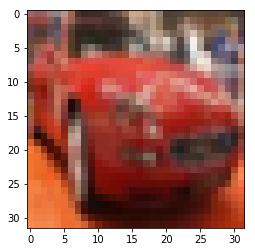

In [216]:
# get imgs for each class
f = open('/Users/fangtiantian/Documents/research/normalization/data/cifar-10-batches-py/data_batch_1', 'rb')

tupled_data= pickle.load(f)
f.close()
labels = tupled_data[b'labels']
img = tupled_data[b'data']
single_img = np.transpose(np.reshape(img[5],(3, 32,32)), (1,2,0))
plt.imshow(single_img)

In [188]:
def quantize(raster, n_colors=32):
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(raster, (width * height, depth))

    model = cluster.KMeans(n_clusters=n_colors)
    labels = model.fit_predict(reshaped_raster)
    palette = model.cluster_centers_.astype(int)
    quantized_raster = np.reshape(
        palette[labels], (width, height, palette.shape[1]))
    return quantized_raster, palette
clus_img, colors_palette = quantize(single_img)
colors_palette = colors_palette / 255.  #(32, 3)

In [189]:
def add_noise(clus_img, colors_palette):
    noise_img = clus_img
    (h, w, _) = clus_img.shape
    for i in range(h):
        for j in range(w):
            p = bernoulli.rvs(1./32)
            if p == 1:
                # uniformly choose a color as noise
                noise_img[i,j] = colors_palette[np.random.randint(32)]
    return noise_img

data = add_noise(clus_img, colors_palette)

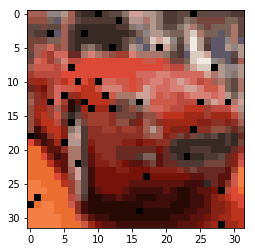

In [190]:
plt.imshow(data/255.)

In [210]:
#load data
img = np.double(data) / 255.
img_mean = np.mean(img)
[M, N, d] = img.shape

#mean-field parameters
sigma  = 0.1  #noise level
y = img #+ sigma*np.random.randn(M, N, d) #y_i ~ N(x_i; sigma^2);
J = 1  #coupling strength (w_ij)
rate = 0.5  #update smoothing rate
max_iter = 15
# ELBO = np.zeros((max_iter, 3))
# Hx_mean = np.zeros(max_iter)

(32, 3)


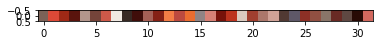

In [192]:
print(colors_palette.shape)
plt.imshow(colors_palette.reshape((1, 32, 3)))

In [211]:
#Mean-Field VI
print("running mean-field variational inference...")
# logodds = multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2) - \
#           multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2)

print(colors_palette.shape)
log_L = []
for i in range(32):
    log_L.append(multivariate_normal.logpdf(y.reshape([-1, 3]), mean=colors_palette[i], cov=sigma**2))
log_L = np.array(log_L)
print(log_L.shape)
denomiator = np.sum(np.exp(log_L), axis=0)
q = np.exp(log_L) / denomiator
print("q", q.shape)

# mu = E_{q_i(x_k)}[x_k]
mu = np.transpose(q).dot(colors_palette)
print("mu", mu.shape)

# a: [32, 1024]
a = colors_palette.dot(np.transpose(mu)) + log_L
print("a", a.shape)

mu = mu.reshape((M, N, 3))
# mu = mu.astype(np.int)
a = a.astype(np.int)
print(mu.shape, a.shape)

running mean-field variational inference...
(32, 3)
(32, 1024)
('q', (32, 1024))
('mu', (1024, 3))
('a', (32, 1024))
((32, 32, 3), (32, 1024))


In [9]:
print(data / 255.)

[[[0.63137255 0.46666667 0.41176471]
  [0.60392157 0.36078431 0.31372549]
  [0.60392157 0.36078431 0.31372549]
  ...
  [0.38039216 0.27843137 0.24705882]
  [0.31372549 0.22352941 0.2       ]
  [0.31372549 0.22352941 0.2       ]]

 [[0.48627451 0.27058824 0.23529412]
  [0.61960784 0.25490196 0.19607843]
  [0.61960784 0.25490196 0.19607843]
  ...
  [0.49411765 0.38823529 0.34117647]
  [0.49411765 0.38823529 0.34117647]
  [0.38039216 0.27843137 0.24705882]]

 [[0.38039216 0.27843137 0.24705882]
  [0.38039216 0.27843137 0.24705882]
  [0.38039216 0.27843137 0.24705882]
  ...
  [0.49411765 0.38823529 0.34117647]
  [0.63137255 0.46666667 0.41176471]
  [0.38039216 0.27843137 0.24705882]]

 ...

 [[0.94901961 0.49019608 0.26666667]
  [0.94901961 0.49019608 0.26666667]
  [0.94901961 0.49019608 0.26666667]
  ...
  [0.62745098 0.16862745 0.09019608]
  [0.7372549  0.18431373 0.10980392]
  [0.76862745 0.28235294 0.19607843]]

 [[0.94901961 0.49019608 0.26666667]
  [0.94901961 0.49019608 0.26666667]


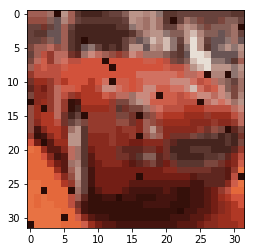

In [59]:
plt.imshow(mu)

In [53]:
print(mu)

[[[0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  ...
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]]

 [[0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  ...
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]]

 [[0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  ...
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]]

 ...

 [[0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  ...
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]]

 [[0.36078431 0.14901961 0.11764706]
  [0.36078431 0.14901961 0.11764706]


In [212]:
from collections import defaultdict
max_iter = 1
rate = 0.5
from tqdm import tqdm

for i in tqdm(range(max_iter)):
    muNew = mu
    # m_mat = np.zeros((M, N, 3))
    # print(mu.shape)
    for ix in range(N):
        for iy in range(M):
            pos = iy + M * ix
            neighborhood = pos + np.array([-1, 1, -M, M])            
            boundary_idx = [iy != 0, iy != M - 1, ix != 0, ix != N - 1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]            
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
#             print muNew[xx,yy]#,nx,ny
            
            # 周围邻居mu的和
#             Sbar = J*np.sum(mu[nx,ny, :], axis=0).reshape((3, 1))
#             print nx.shape
#             import sys; sys.exit(1)
            neigh = np.zeros((32, 1))
            cur_N = np.zeros((32, 1))
            for k in range(32):
                cur_N[k] = multivariate_normal.logpdf(muNew[xx, yy], mean=colors_palette[k], cov=sigma**2)
                for dd in range(nx.shape[0]):
                    neigh[k] = multivariate_normal.logpdf(muNew[nx[dd], ny[dd]], mean=colors_palette[k], cov=sigma**2)
                
                
            update_part_1 = neigh + cur_N 
#             update_part_1 = colors_palette.dot(Sbar) #+ cur_N 
#             print update_part_1            
            
            # print(cur_update)
            cur_update_prob = np.exp(update_part_1) / np.sum(np.exp(update_part_1))
#             cur_update = np.transpose(cur_update_prob).dot(colors_palette).reshape(-1)
            cur_update = colors_palette[np.argmax(cur_update_prob)]
#             print np.argmax(cur_update_prob), colors_palette[np.argmax(cur_update_prob)]

   
            muNew[xx, yy] = (1 - rate) * muNew[xx, yy, :] + rate * cur_update
#             muNew[xx, yy] = cur_update
            # ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy, :])
        #end for
    #end for
    mu = muNew
        
    # colors: [32, 3] * mu: [3, 1024]
    # print(colors_palette.dot(np.transpose(mu.reshape((-1, 3)))).shape)
    # a = colors_palette.dot(np.transpose(mu.reshape((-1, 3)))) + log_L
    # print(a.shape)
    # q = np.exp(a) / np.sum(np.exp(a), axis=0).reshape((1, -1))
    # print(q.shape)
    
    # qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    # qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    # Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    # ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    # Hx_mean[i] = np.mean(Hx) 


100%|██████████| 1/1 [00:17<00:00, 17.76s/it]


In [77]:
# old copy in case
from collections import defaultdict
max_iter = 1
rate = 0.5
from tqdm import tqdm

for i in tqdm(range(max_iter)):
    muNew = mu
    # m_mat = np.zeros((M, N, 3))
    # print(mu.shape)
    for ix in range(N):
        for iy in range(M):
            pos = iy + M * ix
            neighborhood = pos + np.array([-1, 1, -M, M])            
            boundary_idx = [iy != 0, iy != M - 1, ix != 0, ix != N - 1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]            
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
#             print muNew[xx,yy]#,nx,ny
            
            # 周围邻居mu的和
#             Sbar = J*np.sum(mu[nx,ny, :], axis=0).reshape((3, 1))
#             print nx.shape
#             import sys; sys.exit(1)
            neigh = np.zeros((32, 1))
            cur_N = np.zeros((32, 1))
            for k in range(32):
                cur_N[k] = multivariate_normal.logpdf(muNew[xx, yy], mean=colors_palette[k], cov=sigma**2)
                for dd in range(nx.shape[0]):
                    neigh[k] = multivariate_normal.logpdf(muNew[nx[dd], ny[dd]], mean=colors_palette[k], cov=sigma**2)
                
                
            update_part_1 = neigh + cur_N 
#             update_part_1 = colors_palette.dot(Sbar) #+ cur_N 
#             print update_part_1            
            
            # print(cur_update)
            cur_update_prob = np.exp(update_part_1) / np.sum(np.exp(update_part_1))
#             cur_update = np.transpose(cur_update_prob).dot(colors_palette).reshape(-1)
            cur_update = colors_palette[np.argmax(cur_update_prob)]
#             print np.argmax(cur_update_prob), colors_palette[np.argmax(cur_update_prob)]

   
            muNew[xx, yy] = (1 - rate) * muNew[xx, yy, :] + rate * cur_update
#             muNew[xx, yy] = cur_update
            # ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy, :])
        #end for
    #end for
    mu = muNew
        
    # colors: [32, 3] * mu: [3, 1024]
    # print(colors_palette.dot(np.transpose(mu.reshape((-1, 3)))).shape)
    # a = colors_palette.dot(np.transpose(mu.reshape((-1, 3)))) + log_L
    # print(a.shape)
    # q = np.exp(a) / np.sum(np.exp(a), axis=0).reshape((1, -1))
    # print(q.shape)
    
    # qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    # qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    # Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    # ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    # Hx_mean[i] = np.mean(Hx) 

-13.396078431372548

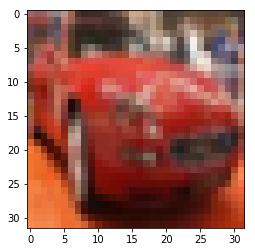

In [220]:
single_img = np.transpose(np.reshape(img[5],(3, 32,32)), (1,2,0))
plt.imshow(single_img)

clus_img, colors_palette = quantize(single_img)
colors_palette = colors_palette  #(32, 3)
data = add_noise(clus_img, colors_palette)

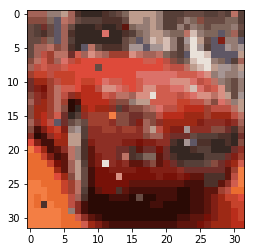

In [229]:
plt.imshow(data)

In [230]:
clean = denoise(data, colors_palette / 255.)


100%|██████████| 5/5 [01:36<00:00, 19.22s/it]


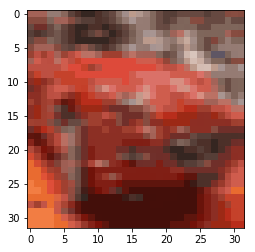

In [231]:
plt.imshow(clean)